<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Galactic Science

## Goal

This notebook shows how to explore the alerts associated to galactic events in the Fink database. We show-case two science cases: variable stars & gravitational microlensing events.

## What is behind?

Each night, Fink cross-matches in real-time alerts from the ZTF public stream with the CDS SIMBAD database (galactic and extragalactic) using the [CDS xmatch service](http://cdsxmatch.u-strasbg.fr/xmatch). Up to 30% of the alerts that survive quality cuts ends up with a counter-part in the  [SIMBAD (Wenger et al. 2020)](https://aas.aanda.org/articles/aas/abs/2000/07/ds1821/ds1821.html) database. Concerning galactic classes, the most frequent are Variable Star of RR Lyr type (`RRLyr`) and Eclipsing binary (`EB*`). On the other hand, we also have a module to detect microlensing events, based on `Lensed Identification Algorithm` ([LIA](https://github.com/dgodinez77/LIA)). 

## Useful links

- API documentation: http://134.158.75.151:24000/api
- Schema of Fink database: http://134.158.75.151:24000/api/v1/columns
- CDS xmatch service: http://cdsxmatch.u-strasbg.fr/xmatch
- SIMBAD description of classes: http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes
- LIA: https://github.com/dgodinez77/LIA

## Environment set up

To run this notebook, you need to import the following libraries (some are already installed in  colab):

In [1]:
# !pip install gatspy
# !pip install seaborn
# !pip install fink_science
# !pip install astropy
# !pip install pyLIMA

import io
import requests

import pandas as pd
import numpy as np

from fink_science.conversion import dc_mag

from gatspy import periodic

from astropy.coordinates import SkyCoord

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels, microltoolbox
from pyLIMA.microloutputs import create_the_fake_telescopes

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
sns.set_context('talk')

## Case study 1: Variable stars in our galaxy

### Association criterion and nightly rate 

Fink cross-matches in real-time alerts from the ZTF public stream with the CDS SIMBAD database (galactic and extragalactic) using the [CDS xmatch service](http://cdsxmatch.u-strasbg.fr/xmatch). Up to 30% of the alerts that survive quality cuts ends up with a counter-part in the SIMBAD database. Concerning galactic classes, the most present are Variable Star of RR Lyr type (`RRLyr`), Eclipsing binary (`EB*`), Long-period variable star (`LPV*`), Variable Star of Mira Cet type (`Mira`). The way we associate alerts to known SIMBAD objects is based on the spatial position only: if the alert is within 1 arcsecond of a known SIMBAD object, they are associated. In case of several objects within a radius of 1 arcsecond, we take the closest one.

### Querying the Fink database by class

Fink has a service to query objects by their class. The list of arguments for getting latest alerts by class can be found at http://134.158.75.151:24000/api/v1/latests, and the available classes can be found at http://134.158.75.151:24000/api/v1/classes. We will focus on classes taken from SIMBAD association, starting with `(SIMBAD)`.


#### Example: search for RRLyr

In [2]:
# Get latests 100 alerts associated to RRLyr
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': '(SIMBAD) RRLyr',
    'n': '100',
  }
)

# Format output in a DataFrame
pdf_rrlyr = pd.read_json(r.content)

You will get a pandas DataFrame containing, whose rows are alerts from the Fink database that are associated to the class `(SIMBAD) RRLyr`. We recall that the DataFrame column schema can be read from http://134.158.75.151:24000/api/v1/columns. In the Fink Web Portal, you would just choose the class from the search bar:

<img src="rrlyr_search.png" width=1000 />

#### Get photometry

The `latests` service will give you latests alerts associated to a particular class, but you will not have the full photometry of each object. For this, you can query the `objects` service using a previously returned `objectId`:

In [3]:
# Get alerts associated with an specific object ID
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': 'ZTF17aaaehtj',
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_rrlyr_phot = pd.read_json(r.content)

#### Extracting some properties

From the DataFrame, you can easily inspect the lightcurve of the object:

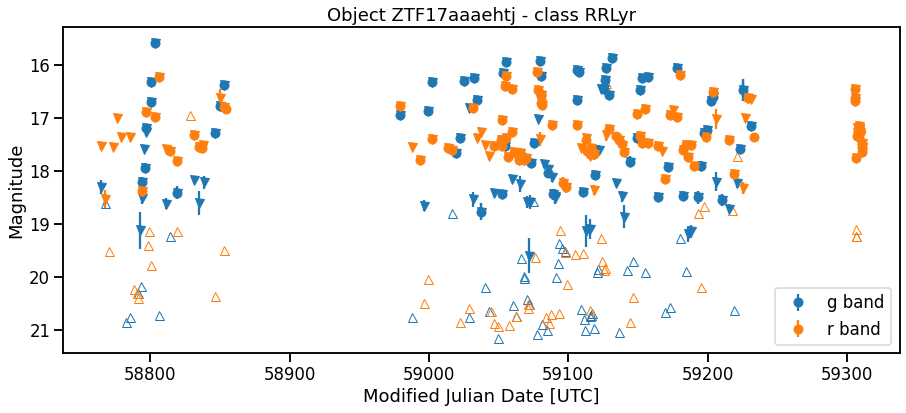

In [4]:
mjd = pdf_rrlyr_phot['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_rrlyr_phot['i:fid']):
    maskFilt = pdf_rrlyr_phot['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_rrlyr_phot['d:tag'] == 'valid'
    plt.errorbar(
        pdf_rrlyr_phot[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskValid & maskFilt]['i:magpsf'],
        pdf_rrlyr_phot[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_rrlyr_phot['d:tag'] == 'upperlim'
    plt.plot(
        pdf_rrlyr_phot[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_rrlyr_phot['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:magpsf'],
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', color=colordic[filt]
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title(
    'Object {} - class {}'.format(
        pdf_rrlyr_phot['i:objectId'].values[0],
        pdf_rrlyr_phot['d:cdsxmatch'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude')
plt.show()

#### Extracting period

In the Fink Web Portal, we provide tools to fit for the period of an object. The fit is done using [gatspy](https://zenodo.org/record/47887) described in [VanderPlas & Ivezic (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...812...18V/abstract). We use a multiband periodogram (LombScargleMultiband) to find the best period. Alternatively, you can manually set the period in days:

<img src="rrlyr_fit.png" width=1000 />

Let's redo this analysis here:

In [5]:
maskValid = pdf_rrlyr_phot['d:tag'] == 'valid'
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf_rrlyr_phot[maskValid]['i:fid'].astype(int).values,
            pdf_rrlyr_phot[maskValid]['i:magpsf'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:sigmapsf'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:magnr'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:sigmagnr'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:magzpsci'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:isdiffpos'].values
        )
    ]
)

jd = pdf_rrlyr_phot[maskValid]['i:jd']
model = periodic.LombScargleMultiband(
    Nterms_base=1,
    Nterms_band=1,
    fit_period=True
)

# Not sure about that...
model.optimizer.period_range = (0.1, 1.2)
model.optimizer.quiet = True

model.fit(
    jd.astype(float),
    mag_dc,
    err_dc,
    pdf_rrlyr_phot[maskValid]['i:fid'].astype(int)
)

period = model.best_period
phase = jd.astype(float).values % period
tfit = np.linspace(0, period, 100)

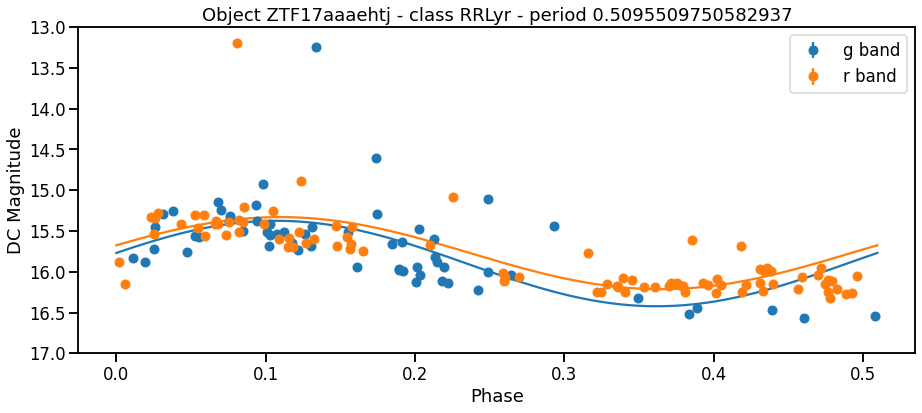

In [6]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_rrlyr_phot['i:fid']):
    maskFilt = pdf_rrlyr_phot[maskValid]['i:fid'] == filt
    plt.errorbar(
        phase[maskFilt], 
        mag_dc[maskFilt],
        err_dc[maskFilt],
        ls = '', marker='o', color=colordic[filt], 
        label='{} band'.format(filtdic[filt])
    )
    
    plt.plot(tfit, model.predict(tfit, period=period, filts=filt))

plt.ylim(13, 17)
plt.gca().invert_yaxis()
plt.legend()
plt.title(
    'Object {} - class {} - period {}'.format(
        pdf_rrlyr_phot['i:objectId'].values[0],
        pdf_rrlyr_phot['d:cdsxmatch'].values[0],
        period
    )
)
plt.xlabel('Phase')
plt.ylabel('DC Magnitude');
plt.show()

You can actually check the validity of the period fit on [ASAS-SN](https://asas-sn.osu.edu/variables?ra=346.7715507&dec=31.7946076&radius=0.5&vmag_min=&vmag_max=&amplitude_min=&amplitude_max=&period_min=&period_max=&lksl_min=&lksl_max=&class_prob_min=&class_prob_max=&parallax_over_err_min=&parallax_over_err_max=&name=&references[]=I&references[]=II&references[]=III&references[]=IV&references[]=V&references[]=VI&sort_by=raj2000&sort_order=asc&show_non_periodic=true&show_without_class=true&asassn_discov_only=false&).

## Case study 2: Gravitational microlensing 

We deployed a science module to find (early) gravitational microlensing events. The microlensing classification module is based on the Lens Identification Algorithm (LIA) presented in [Godines et al. (2019)](). In short, a Random Forest algorithm is trained with simulated light-curves similar in cadence and noise to the associated survey of interest (currently ZTF). Of course, we receive _alerts_ with limited photometry size (up to 30 days with ZTF), so the game is very challenging!

### Association criterion and rate

An event is considered as Microlensing candidate if the classifier simultaneously favoured microlensing in all available bands (`g`, `r`). In addition, we make a cut on the number of times the light of this event has varied (at 3 sigma) since the beginning of the survey. This last cut is here to removes variable stars with long-trend.

In [7]:
# Get all latests alerts associated to Microlensing
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'Microlensing candidate',
    'n': '1000',
  }
)

# Format output in a DataFrame
pdf_mulens = pd.read_json(r.content)
print(len(pdf_mulens))

428


We have currently less than 500 alerts in 2 years of data flagged as Microlensing candidates. Let's see if they are associated to a known transient in SIMBAD:

In [8]:
pdf_mulens.groupby('d:cdsxmatch').count()

,d:knscore,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,i:classtar,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
d:cdsxmatch,,,,,,,,,,,,,,,,,,,,,
Fail,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,1,1,3
Unknown,421,425,425,425,425,425,425,425,425,425,...,425,425,425,425,425,425,425,86,25,425


A priori no (`cdsxmatch = Unknown`). Note that `cdsxmatch = Fail` means we couldn't perform the crossmatch with SIMBAD in real time (downtime, or network error, or ...). We usually recompute it on a later time. 

### Spatial distribution

Let's see the spatial distribution of these events. For this, we will change coordinate to galactic ones:

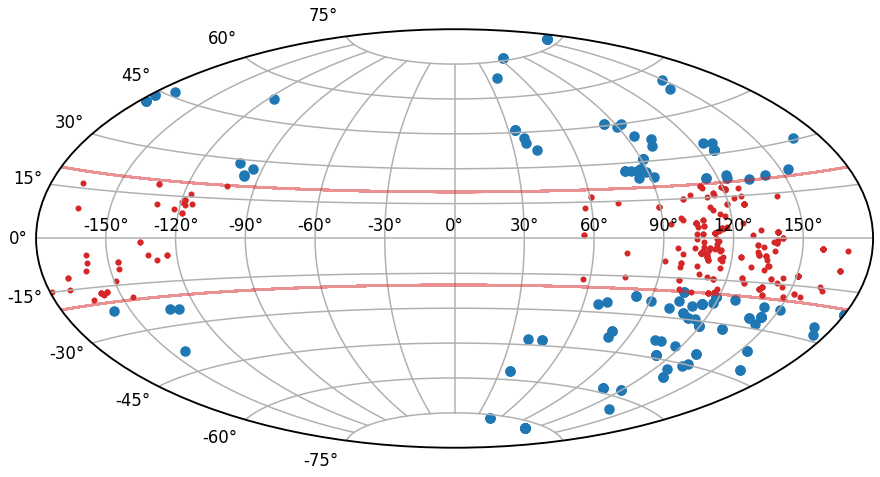

In [9]:
gal = SkyCoord(pdf_mulens['i:ra'], pdf_mulens['i:dec'], unit='deg').galactic

fig = plt.figure(figsize=(15, 10))

ax = plt.subplot(projection='aitoff')

mask_gal = np.abs(gal.b.deg) < 20

plt.scatter(gal.l.wrap_at('180d').radian[~mask_gal], gal.b.radian[~mask_gal], color='C0', alpha=1, marker='o')
plt.scatter(gal.l.wrap_at('180d').radian[mask_gal], gal.b.radian[mask_gal], color='C3', alpha=1, marker='.')

x = np.arange(-180, 180, 0.1)
plt.plot(x, [20*np.pi/180]*len(x), color='C3', alpha=0.5)
plt.plot(x, [-20*np.pi/180]*len(x), color='C3', alpha=0.5)

plt.grid();

We draw a (arbitrary) line at galactic latitude `|b| < 20` degrees to highlight more likely galactic candidates.

### Closer look to a candidate

We could look at all candidates, but let's focus only on one candidate for demonstration purposes:

In [10]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': 'ZTF18acsbhrp',
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_mulens_single = pd.read_json(r.content)

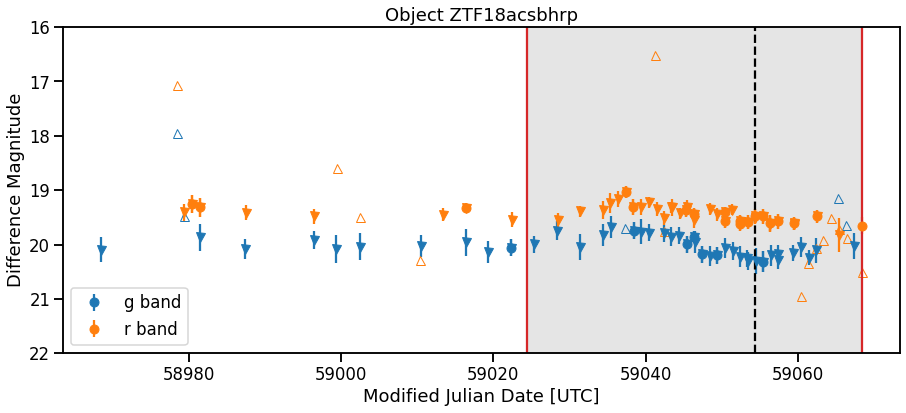

In [11]:
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskValid & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_mulens_single['d:tag'] == 'upperlim'
    plt.plot(
        pdf_mulens_single[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_mulens_single['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_mulens_single[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskBadquality & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', color=colordic[filt]
    )

    
# Highlight dates where it was flagged as an ML event
c1 = pdf_mulens_single['d:mulens_class_1'] == 'ML'
c2 = pdf_mulens_single['d:mulens_class_2'] == 'ML'
jd0 = np.min(pdf_mulens_single[c1 & c2]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c1 & c2]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c1 & c2]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([15, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')


plt.ylim(16, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title(
    'Object {}'.format(
        pdf_mulens_single['i:objectId'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');

The data in between the red lines is favoured as Microlensing by the classifier, and the first microlensing trigger is shown with the black line (recall alerts carry up to 30 days of history). On the Fink Science Portal, you can then try to extract Microlensing paramaters. The fit is done using [pyLIMA](https://github.com/ebachelet/pyLIMA) described in [Bachelet et al (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..203B/abstract). We use a simple PSPL model to fit the data. Here is a screenshot of the Microlensing tab in the portal for this event:

<img src="ml_fit.png" width=1000 />


Let's redo this fit here for demonstration purposes:

In [12]:
# Take only valid measurements
pdf = pdf_mulens_single[pdf_mulens_single['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

# Use DC magnitude instead of difference mag
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf['i:fid'].astype(int).values,
            pdf['i:magpsf'].astype(float).values,
            pdf['i:sigmapsf'].astype(float).values,
            pdf['i:magnr'].astype(float).values,
            pdf['i:sigmagnr'].astype(float).values,
            pdf['i:magzpsci'].astype(float).values,
            pdf['i:isdiffpos'].values
        )
    ]
)

# pyLIMA magic
current_event = event.Event()
current_event.name = pdf['i:objectId'].values[0]

current_event.ra = pdf['i:ra'].values[0]
current_event.dec = pdf['i:dec'].values[0]

filts = {1: 'g', 2: 'r'}
for fid in np.unique(pdf['i:fid'].values):
    mask = pdf['i:fid'].values == fid
    telescope = telescopes.Telescope(
        name='ztf_{}'.format(filts[fid]),
        camera_filter=format(filts[fid]),
        light_curve_magnitude=np.transpose(
            [
                pdf['i:jd'].values[mask],
                mag_dc[mask],
                err_dc[mask]
            ]
        ),
        light_curve_magnitude_dictionnary={
            'time': 0,
            'mag': 1,
            'err_mag': 2
        }
    )

    current_event.telescopes.append(telescope)

# Simplest model
mulens_model = microlmodels.create_model('PSPL', current_event)
current_event.fit(mulens_model, 'DE')

# 4 parameters model
dof = len(pdf) - 4 - 1

results = current_event.fits[0]

normalised_lightcurves = microltoolbox.align_the_data_to_the_reference_telescope(results, 0, results.fit_results)

# Model
create_the_fake_telescopes(results, results.fit_results)

telescope_ = results.event.fake_telescopes[0]

flux_model = mulens_model.compute_the_microlensing_model(telescope_, results.model.compute_pyLIMA_parameters(results.fit_results))[0]

time = telescope_.lightcurve_flux[:, 0]
magnitude = microltoolbox.flux_to_magnitude(flux_model)

# fitted parameters
names = results.model.model_dictionnary
params = results.fit_results
err = np.diag(np.sqrt(results.fit_covariance))


Start fit on ZTF18acsbhrp, with model PSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15.8111
differential_evolution step 2: f(x)= 14.4961
differential_evolution step 3: f(x)= 14.4961
differential_evolution step 4: f(x)= 14.4961
differential_evolution step 5: f(x)= 14.4961
differential_evolution step 6: f(x)= 14.4961
differential_evolution step 7: f(x)= 14.4961
DE converge to objective function : f(x) =  14.496149845627821
DE converge to parameters : =  ['2459062.5650159395' '0.11131372523151783' '191.0558130209858']
trust_region_reflective  : TRF fit SUCCESS
[2458980.9745255006, 0.7355119906906487, 106.07851940858707, 2051.0611706906902, 0.6561602290613897, 3193.438335965394, 1.1636066467546076, 15.727967208063191]
differential_evolution  : Differential evolution fit SUCCESS


Finally plot the fit on top of the (rescaled) measurements:

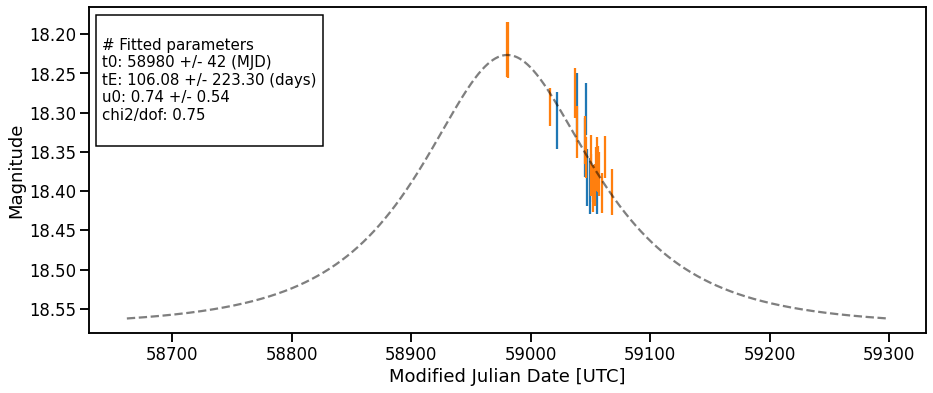

In [13]:
fig = plt.figure(figsize=(15, 6))
ax = plt.subplot()

plt.errorbar(
    [t - 2400000.5 for t in normalised_lightcurves[0][:, 0]],
    normalised_lightcurves[0][:, 1],
    normalised_lightcurves[0][:, 2],
    ls=''
)

plt.errorbar(
    [t - 2400000.5 for t in normalised_lightcurves[1][:, 0]],
    normalised_lightcurves[1][:, 1],
    normalised_lightcurves[1][:, 2],
    ls=''
)

plt.plot(
    [t - 2400000.5 for t in time],
    magnitude,
    color='black', ls='--', alpha=0.5
)

plt.gca().invert_yaxis()

msg = """
# Fitted parameters
t0: {:.0f} +/- {:.0f} (MJD)
tE: {:.2f} +/- {:.2f} (days)
u0: {:.2f} +/- {:.2f}
chi2/dof: {:.2f}
""".format(
    params[names['to']] - 2400000.5,
    err[names['to']],
    params[names['tE']],
    err[names['tE']],
    params[names['uo']],
    err[names['uo']],
    params[-1] / dof
)
anchored_text = AnchoredText(msg, loc=2, prop={'fontsize': 15})
ax.add_artist(anchored_text)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

Not too bad - although we need much more data to conclude on the nature of the object ;-)

### Inspecting the event using the full ZTF lightcurve

To futher check this event, we can query its data using the ZTF lightcurve API:

In [14]:
maskNone = pdf_mulens_single['d:tag'] == 'valid'
ra0 = np.mean(pdf_mulens_single[maskNone]['i:ra'].values)
dec0 = np.mean(pdf_mulens_single[maskNone]['i:dec'].values)

r = requests.post(
    'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves', 
    data={'POS': 'CIRCLE {} {} 0.0004'.format(ra0, dec0), 
          'BAD_CATFLAGS_MASK': 32768, 
          'FORMAT': 'csv'
         }
)

pdf = pd.read_csv(io.StringIO(r.text))

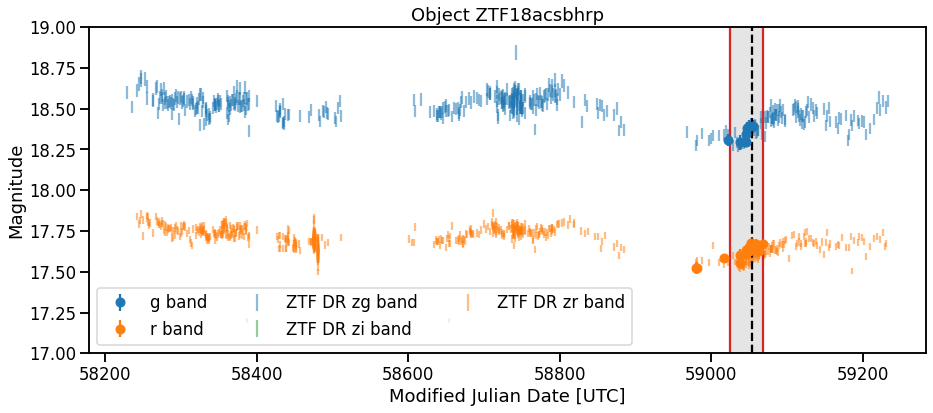

In [15]:
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    
    # Use DC magnitude
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_mulens_single[maskValid & maskFilt]['i:fid'].astype(int).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magpsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmagnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magzpsci'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:isdiffpos'].values
            )
        ]
    )

    
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        mag_dc,
        err_dc,
        ls = '', marker='o', color=colordic[filt], 
        label='{} band'.format(filtdic[filt])
    )

    
# Highlight dates where it was flagged as an ML event
c1 = pdf_mulens_single['d:mulens_class_1'] == 'ML'
c2 = pdf_mulens_single['d:mulens_class_2'] == 'ML'
jd0 = np.min(pdf_mulens_single[c1 & c2]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c1 & c2]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c1 & c2]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([15, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')


colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf['filtercode']):
    maskFilt = pdf['filtercode'] == filt
    plt.errorbar(
        pdf[maskFilt]['mjd'], 
        pdf[maskFilt]['mag'], 
        pdf[maskFilt]['magerr'], 
        ls='', color=colordic[filt], alpha=0.5,
        label='ZTF DR {} band'.format(filt))

plt.ylim(19, 17)
plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title(
    'Object {}'.format(
        pdf_mulens_single['i:objectId'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

Very likely a variable star! Too bad!

### Concluding remarks

Doing early microlensing on ZTF alerts is challenging as we work live with very limited history (up to 30 days in the past). We could aggregate in real-time alert data and history data contained in our database, but the scaling of this becomes challenging with the volume of data. On the other end, LSST alert will probably contain a longer history (currently up to 1 year of data) which will help to caracterize the baseline (mean, and stability of the flux pre-event). Stay tuned!

## How to reach us

An issue to report, or a question to ask: contact@fink-broker.org!